Set Play Shots - Expected Miss Model - Model Evaluation - GBM

In [1]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/")

In [2]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

from expected_score_model.config import set_shots_file_path
from expected_score_model.domain.contracts.modelling_data_contract import ModellingDataContract
from expected_score_model.domain.modelling.supermodel import SuperXGBClassifier
from expected_score_model.domain.modelling.model_evaluation import XGBClassifierEvaluator

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


New Model

In [3]:
new_version = 3
model_name = "expected_miss_set"
model_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/models"
preproc_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/preprocessors"

Comparison Model

In [4]:
old_version = new_version - 1
compare_train_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/train_predictions_"+model_name+"_v"+str(old_version)+".csv"
compare_test_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/test_predictions_"+model_name+"_v"+str(old_version)+".csv"

Response

In [5]:
RESPONSE = ModellingDataContract.RESPONSE_MISS

Features

In [6]:
FEATURES = ModellingDataContract.set_goal_modelling_feature_list

Load Data

In [8]:
df_modelling = pd.read_csv(set_shots_file_path)
df_modelling.tail()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Goal,Behind,Miss,Score,Home_Score,Away_Score,Home_Current_Score,Away_Current_Score,Current_Margin,Event_Type0,Event_Type1,Event_Type2,Event_Type3,x0,x1,x2,x3,y0,y1,y2,y3,Quarter_Duration0,Quarter_Duration1,Quarter_Duration2,Quarter_Duration3,Chain_Duration,Time_Since_Last_Action,Distance_Since_Last_Action,Distance_to_Right_Goal_x,Distance_to_Middle_y,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Angle_to_Middle_Goal_degrees,Visible_Goal_Angle,Visible_Goal_Angle_degrees,Visible_Behind_Angle,Visible_Behind_Angle_degrees,Squared_Distance_to_Middle_Goal,Log_Distance_to_Middle_Goal,Set_Shot,GoalTrainingSet,GoalTestSet,GoalValidationSet,BehindTrainingSet,BehindTestSet,BehindValidationSet,MissTrainingSet,MissTestSet,MissValidationSet
11052,208,possGain,behind,1663.0,4,634,683.0,Geelong,Geelong,Tom Hawkins,Tom_Hawkins,Kick,41.0,25.0,ineffective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,0,1,0,1,1,0,105.0,32.0,73.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,41.0,48.0,48.0,26.0,25.0,21.0,21.0,14.0,683.0,644.0,642.0,641.0,49.0,39.0,8.062258,39.0,25.0,46.324939,0.570040,32.660913,0.116867,6.695990,0.364585,20.889203,1521.0,3.663562,True,True,False,False,True,False,False,True,False,False
11053,212,kickIn,goal,1730.0,4,787,885.0,Geelong,Geelong,Patrick Dangerfield,Patrick_Dangerfield,Kick,51.0,43.0,ineffective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,0,6,6,0,107.0,33.0,74.0,Kick,Contested Mark,Contest Target,Kick Inside 50 Result,51.0,53.0,53.0,53.0,43.0,38.0,38.0,38.0,885.0,852.0,851.0,850.0,98.0,33.0,5.385165,29.0,43.0,51.865210,0.977446,56.003541,0.069260,3.968302,0.214332,12.280314,841.0,3.367296,True,False,False,True,True,False,False,True,False,False
11054,213,centreBounce,goal,1754.0,4,956,979.0,Sydney,Sydney,Paddy McCartin,Paddy_McCartin,Kick,66.0,0.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,0,6,0,6,119.0,33.0,86.0,Kick,Free For,Kick Inside 50 Result,Kick Into F50,66.0,74.0,74.0,27.0,0.0,0.0,0.0,17.0,979.0,977.0,968.0,967.0,23.0,2.0,8.000000,14.0,0.0,14.000000,0.000000,0.000000,0.482343,27.636207,2.588598,148.315731,196.0,2.639057,True,True,False,False,True,False,False,False,True,False
11055,219,centreBounce,goal,1846.0,4,1252,1266.0,Sydney,Sydney,Chad Warner,Chad_Warner,Kick,26.0,3.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,0,6,0,6,125.0,39.0,86.0,Kick,Uncontested Mark,Ground Kick,Handball,26.0,18.0,-5.0,-2.0,3.0,2.0,-4.0,3.0,1266.0,1265.0,1264.0,1260.0,14.0,1.0,8.062258,54.0,3.0,54.083269,0.055499,3.179830,0.118569,6.793500,0.365993,20.969862,2916.0,3.988984,True,True,False,False,True,False,False,True,False,False
11056,228,centreBounce,goal,1912.0,4,1519,1560.0,Geelong,Geelong,Jeremy Cameron,Jeremy_Cameron,Kick,41.0,21.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,0,6,6,0,131.0,45.0,86.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,41.0,49.0,49.0,25.0,21.0,17.0,17.0,33.0,1560.0,1535.0,1532.0,1531.0,41.0,25.0,8.944272,39.0,21.0,44.294469,0.493941,28.300756,0.127885,7.327246,0.400462,22.944787,1521.0,3.663562,True,True,False,False,True,False,False,True,False,False


In [9]:
df_modelling[['ballUp', 'centreBounce', 'kickIn', 'possGain', 'throwIn']] = pd.get_dummies(df_modelling['Initial_State'])

In [10]:
training_data = df_modelling[df_modelling[RESPONSE+"TrainingSet"]]
test_data = df_modelling[df_modelling[RESPONSE+"TestSet"]]
cal_data = df_modelling[df_modelling[RESPONSE+"ValidationSet"]]

In [11]:
X_train, y_train = training_data.drop(columns=[RESPONSE]), training_data[RESPONSE]
X_test, y_test = test_data.drop(columns=[RESPONSE]), test_data[RESPONSE]
X_cal, y_cal = cal_data.drop(columns=[RESPONSE]), cal_data[RESPONSE]

In [12]:
X_test.head()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Goal,Behind,Score,Home_Score,Away_Score,Home_Current_Score,Away_Current_Score,Current_Margin,Event_Type0,Event_Type1,Event_Type2,Event_Type3,x0,x1,x2,x3,y0,y1,y2,y3,Quarter_Duration0,Quarter_Duration1,Quarter_Duration2,Quarter_Duration3,Chain_Duration,Time_Since_Last_Action,Distance_Since_Last_Action,Distance_to_Right_Goal_x,Distance_to_Middle_y,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Angle_to_Middle_Goal_degrees,Visible_Goal_Angle,Visible_Goal_Angle_degrees,Visible_Behind_Angle,Visible_Behind_Angle_degrees,Squared_Distance_to_Middle_Goal,Log_Distance_to_Middle_Goal,Set_Shot,GoalTrainingSet,GoalTestSet,GoalValidationSet,BehindTrainingSet,BehindTestSet,BehindValidationSet,MissTrainingSet,MissTestSet,MissValidationSet,ballUp,centreBounce,kickIn,possGain,throwIn
2,34,possGain,behind,354.0,1,1015,1080.0,Sydney,Sydney,Josh P. Kennedy,Josh_P._Kennedy,Kick,45.0,16.0,ineffective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,0,1,1,0,1,18.0,8.0,10.0,Kick,Uncontested Mark,Kick,Handball Received,45.0,48.0,34.0,34.0,16.0,13.0,1.0,-2.0,1080.0,1046.0,1045.0,1045.0,65.0,34.0,4.242641,33.0,16.0,36.674242,0.451453,25.866357,0.158231,9.065951,0.505731,28.976251,1089.0,3.496508,True,False,False,True,False,False,True,False,True,False,0,0,0,1,0
4,59,centreBounce,goal,578.0,2,0,43.0,Sydney,Sydney,Callum Mills,Callum_Mills,Kick,33.0,12.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,6,0,6,20.0,16.0,4.0,Kick,Uncontested Mark,Kick Inside 50 Result,Kick Into F50,33.0,40.0,40.0,9.0,12.0,11.0,11.0,-8.0,43.0,21.0,20.0,20.0,43.0,22.0,7.071068,45.0,12.0,46.572524,0.260602,14.931417,0.133410,7.643825,0.416017,23.835998,2025.0,3.806662,True,True,False,False,True,False,False,False,True,False,0,1,0,0,0
6,72,possGain,goal,696.0,2,462,506.0,Sydney,Sydney,Isaac Heeney,Isaac_Heeney,Kick,47.0,35.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,6,0,6,20.0,28.0,-8.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,47.0,53.0,53.0,42.0,35.0,27.0,27.0,41.0,506.0,468.0,466.0,465.0,44.0,38.0,10.000000,31.0,35.0,46.754679,0.845930,48.468229,0.091187,5.224603,0.284262,16.287036,961.0,3.433987,True,True,False,False,False,False,True,False,True,False,0,0,0,1,0
10,108,possGain,goal,982.0,2,1782,1859.0,Sydney,Sydney,Sam Reid,Sam_Reid,Kick,40.0,36.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,6,0,6,50.0,46.0,4.0,Kick,Uncontested Mark,Kick,Uncontested Mark,40.0,44.0,43.0,50.0,36.0,32.0,48.0,40.0,1859.0,1835.0,1833.0,1814.0,77.0,24.0,5.656854,38.0,36.0,52.345009,0.758378,43.451842,0.089092,5.104600,0.275545,15.787586,1444.0,3.637586,True,True,False,False,False,True,False,False,True,False,0,0,0,1,0
12,132,possGain,goal,1168.0,3,422,469.0,Sydney,Sydney,Logan McDonald,Logan_McDonald,Kick,47.0,-4.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,6,0,6,57.0,58.0,-1.0,Kick,Mark On Lead,Kick,Gather,47.0,55.0,30.0,22.0,-4.0,-4.0,2.0,6.0,469.0,434.0,432.0,430.0,47.0,35.0,8.000000,31.0,4.0,31.256999,0.128323,7.352379,0.205222,11.758330,0.672664,38.540807,961.0,3.433987,True,True,False,False,True,False,False,False,True,False,0,0,0,1,0


Preprocess Data

In [13]:
# preprocessor = DataPreprocessor()
# preprocessor.fit(X_train)

# X_train_preproc = preprocessor.transform(X_train)
# X_test_preproc = preprocessor.transform(X_test)

In [14]:
X_train_preproc = X_train[FEATURES]
X_test_preproc = X_test[FEATURES]

In [15]:
X_train_preproc.shape, X_test_preproc.shape

((7076, 9), (2212, 9))

In [16]:
X_train_preproc.head()

,x0,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Visible_Goal_Angle,ballUp,centreBounce,kickIn,possGain,throwIn
1,52.0,43.600459,0.931882,0.088007,0,0,0,1,0
3,59.0,33.015148,0.957589,0.112618,0,0,0,0,1
5,52.0,44.407207,0.945311,0.084822,0,0,0,1,0
7,38.0,40.311289,0.124355,0.158537,0,0,0,1,0
8,42.0,36.055513,0.055499,0.178638,0,1,0,0,0


In [17]:
X_test_preproc.head()

,x0,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Visible_Goal_Angle,ballUp,centreBounce,kickIn,possGain,throwIn
2,45.0,36.674242,0.451453,0.158231,0,0,0,1,0
4,33.0,46.572524,0.260602,0.133410,0,1,0,0,0
6,47.0,46.754679,0.845930,0.091187,0,0,0,1,0
10,40.0,52.345009,0.758378,0.089092,0,0,0,1,0
12,47.0,31.256999,0.128323,0.205222,0,0,0,1,0


Load Model

In [18]:
super_xgb = joblib.load(model_file_path + "/" + model_name + "_v" + str(new_version) + ".joblib")

In [19]:
super_xgb.xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.33216871718042384, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.004318112801961913, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.62...7156844897, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=12, missing=nan,
              monotone_constraints={'Angle_to_Middle_Goal': -1,
                                    'Distance_to_Middle_Goal': -1,
                                    'Visible_Goal_Angle': 1, 'x0': -1},
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Get Predictions

In [20]:
train_preds = super_xgb.predict(X_train_preproc)
test_preds = super_xgb.predict(X_test_preproc)

In [21]:
train_probas = super_xgb.predict_proba(X_train_preproc)[:, 1]
test_probas = super_xgb.predict_proba(X_test_preproc)[:, 1]

In [22]:
train_cal_probas = super_xgb.predict_proba(X_train_preproc, calibrate=True)
test_cal_probas = super_xgb.predict_proba(X_test_preproc, calibrate=True)

Compare Model

In [23]:
compare_train_data = pd.read_csv(compare_train_predictions_file_path)
compare_test_data = pd.read_csv(compare_test_predictions_file_path)

In [24]:
compare_train_data = compare_train_data.rename(columns = {'xgb_preds':'old_preds',
                                                          'xgb_probas':'old_probas'})
compare_test_data = compare_test_data.rename(columns = {'xgb_preds':'old_preds',
                                                        'xgb_probas':'old_probas'})

In [25]:
training_data.shape, compare_train_data.shape

((7076, 79), (8749, 15))

In [26]:
training_data = pd.merge(training_data, compare_train_data[["Match_ID", "Chain_Number", "Order", 'old_preds', 'old_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])
test_data = pd.merge(test_data, compare_test_data[["Match_ID", "Chain_Number", 'Order', 'old_preds', 'old_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])

Evaluate Model

In [27]:
training_data['xgb_preds'] = train_preds
training_data['xgb_probas'] = train_probas
training_data['xgb_cal_probas'] = train_cal_probas

train_xgb_evals = XGBClassifierEvaluator(model = super_xgb.xgb_model,
                                       data = training_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_cal_probas",
                                       expected_label_name = "xgb_preds",
                                       compare_name='xgb_probas',
                                       compare_label_name="xgb_preds"
                                       )

In [28]:
test_data['xgb_preds'] = test_preds
test_data['xgb_probas'] = test_probas
test_data['xgb_cal_probas'] = test_cal_probas

test_xgb_evals = XGBClassifierEvaluator(model = super_xgb.xgb_model,
                                       data = test_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_cal_probas",
                                       expected_label_name = "xgb_preds",
                                       compare_name = "xgb_probas",
                                       compare_label_name="xgb_preds"
                                       )

Model Averages

In [29]:
training_data[[RESPONSE, 'xgb_probas', 'xgb_cal_probas', 'old_probas']].describe()

,Miss,xgb_probas,xgb_cal_probas,old_probas
count,7076.000000,7076.000000,7076.000000,5588.000000
mean,0.125071,0.125818,0.123113,0.125192
std,0.330822,0.056990,0.061790,0.121796
min,0.000000,0.036947,0.057458,0.010062
25%,0.000000,0.088512,0.091940,0.027562
50%,0.000000,0.124886,0.117569,0.082495
75%,0.000000,0.145248,0.133198,0.184196
max,1.000000,0.501279,0.657390,0.723459


In [30]:
test_data[[RESPONSE, 'xgb_probas', 'xgb_cal_probas', 'old_probas']].describe()

,Miss,xgb_probas,xgb_cal_probas,old_probas
count,2212.000000,2212.000000,2212.000000,471.000000
mean,0.125226,0.126418,0.123802,0.121407
std,0.331050,0.058092,0.062927,0.123533
min,0.000000,0.036947,0.057458,0.010062
25%,0.000000,0.088512,0.091940,0.025482
50%,0.000000,0.124886,0.117569,0.075372
75%,0.000000,0.145248,0.133198,0.176757
max,1.000000,0.501279,0.657390,0.620020


Plots

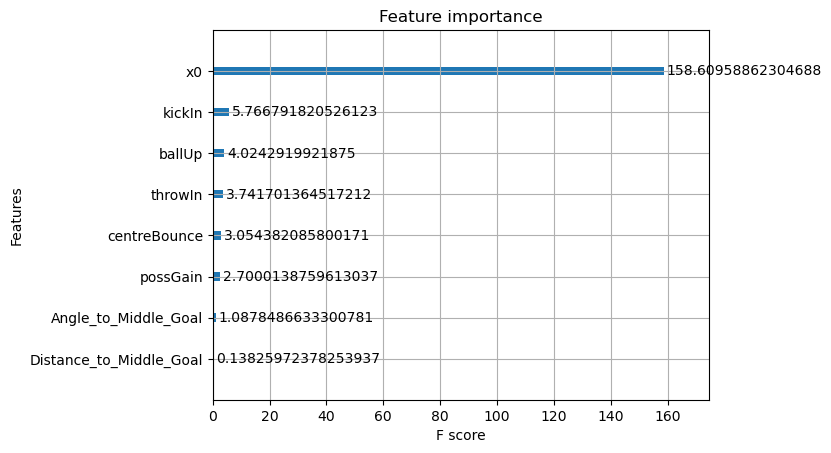

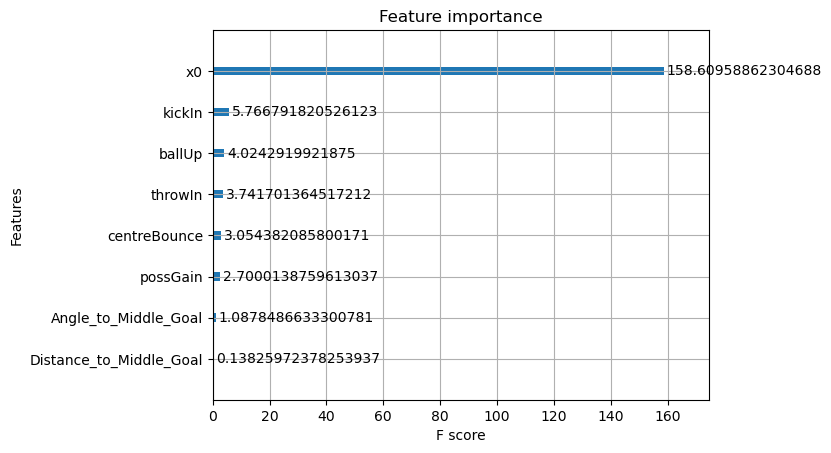

In [31]:
train_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")
test_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

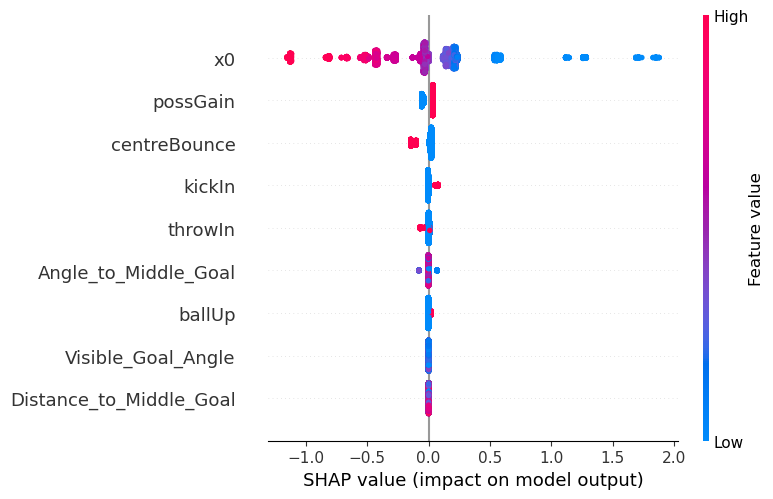

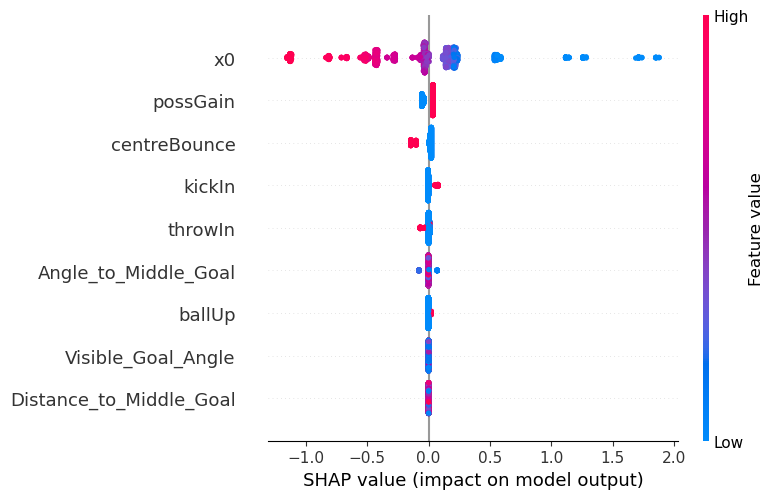

In [32]:
train_xgb_evals.plot_shap_summary_plot()
test_xgb_evals.plot_shap_summary_plot()

In [33]:
top_features = test_xgb_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['x0',
 'possGain',
 'centreBounce',
 'kickIn',
 'throwIn',
 'Angle_to_Middle_Goal',
 'ballUp',
 'Distance_to_Middle_Goal',
 'Visible_Goal_Angle']

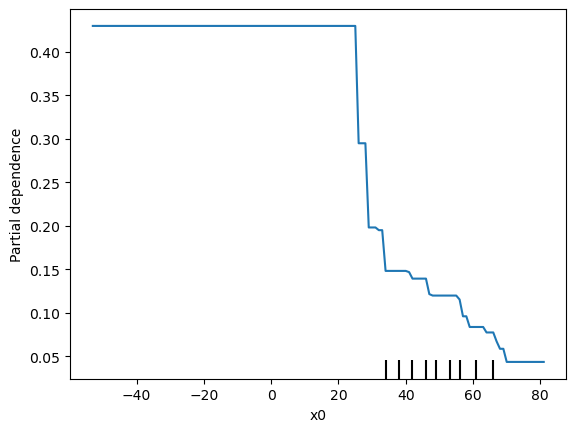

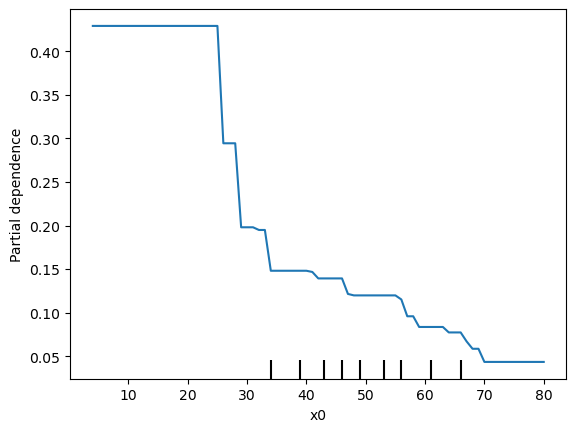

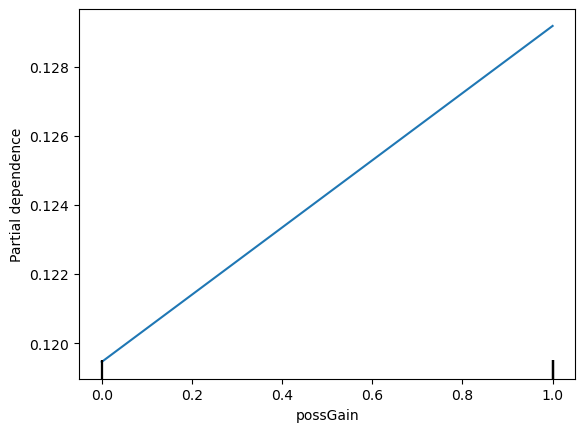

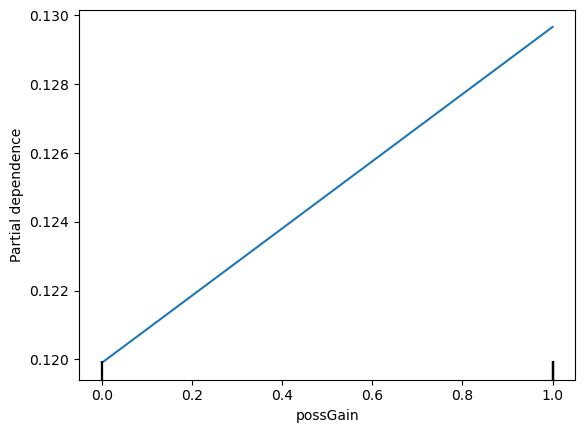

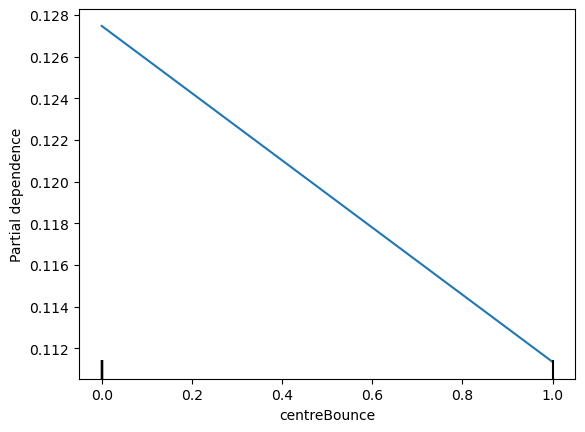

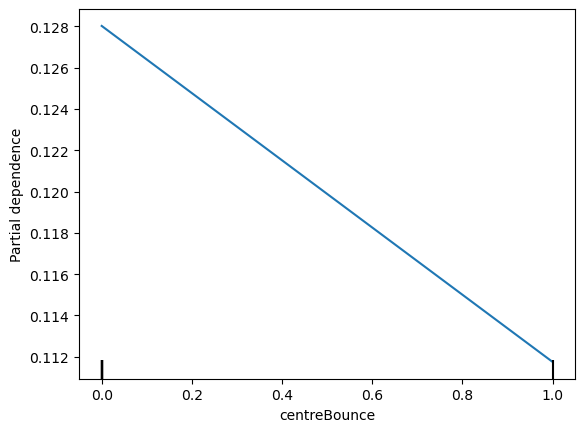

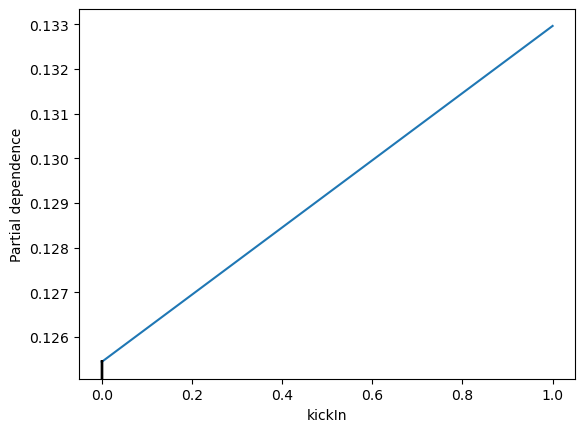

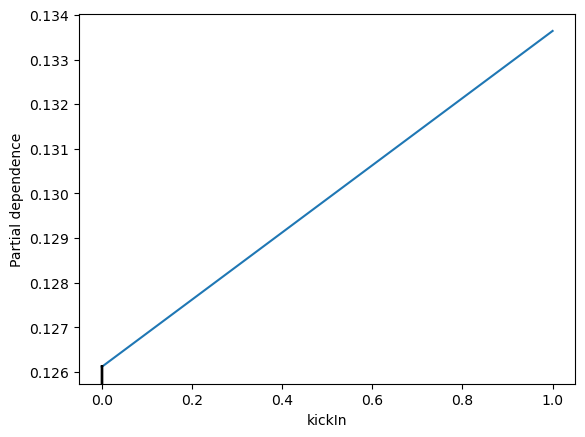

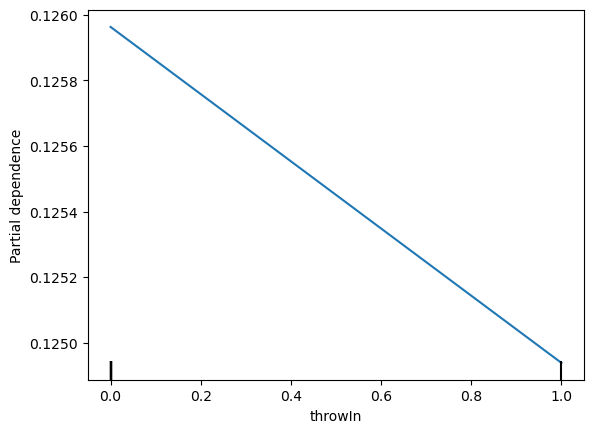

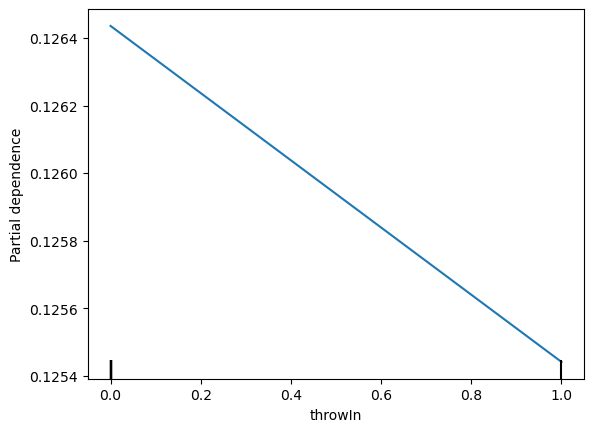

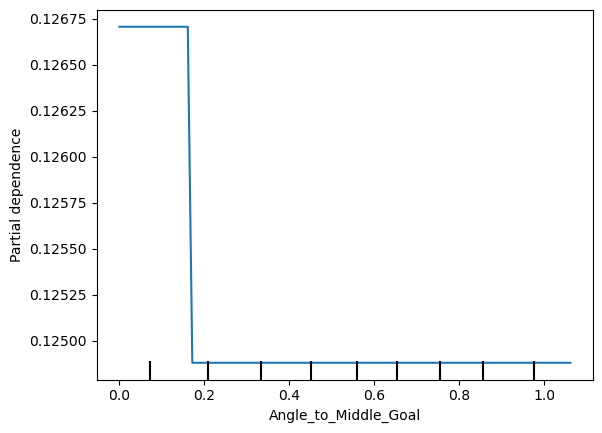

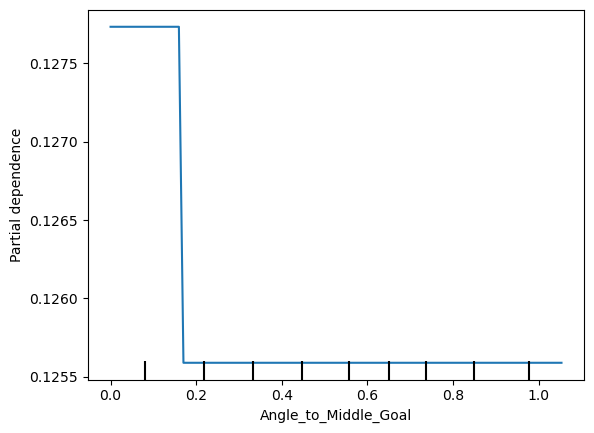

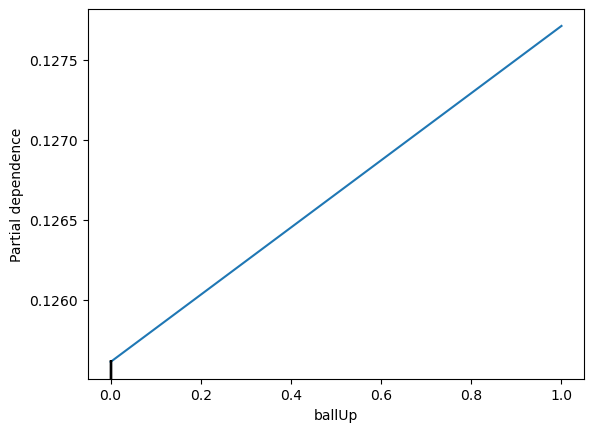

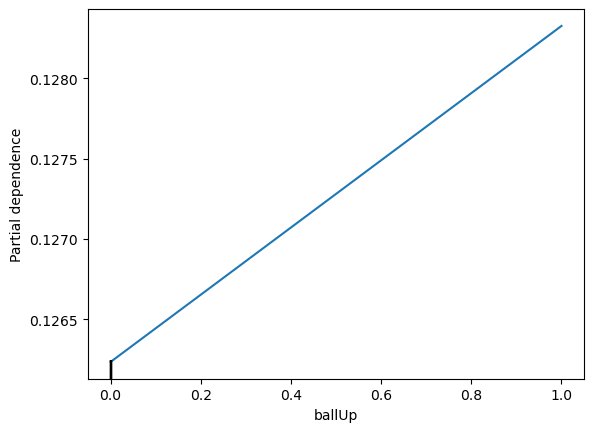

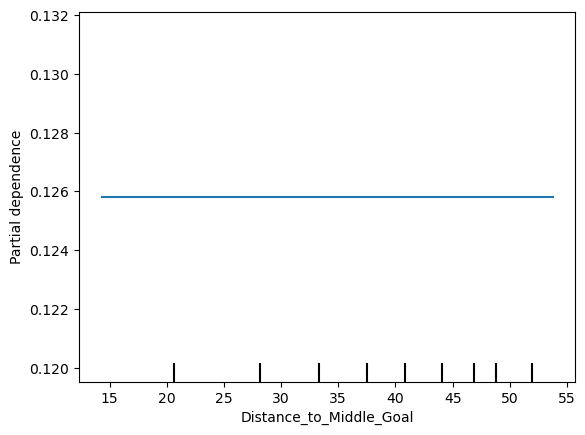

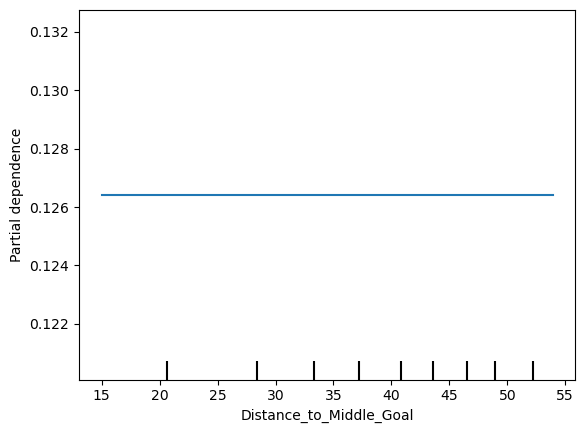

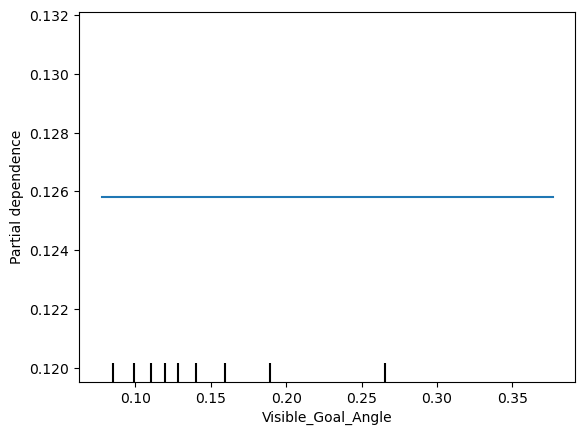

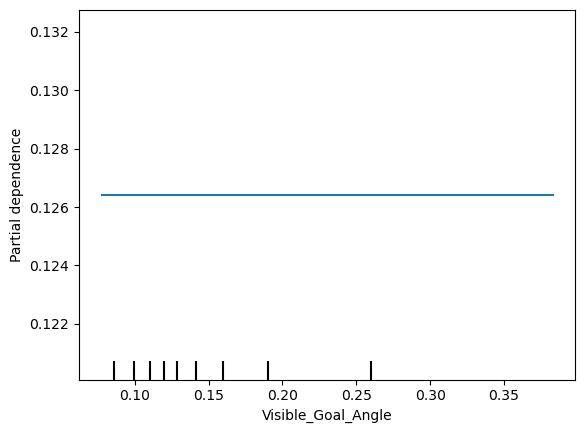

In [34]:
for col in top_10_features:
    train_xgb_evals.plot_pdp([col])
    test_xgb_evals.plot_pdp([col])

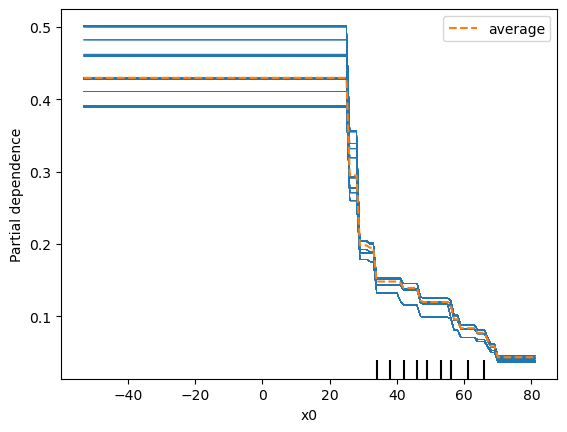

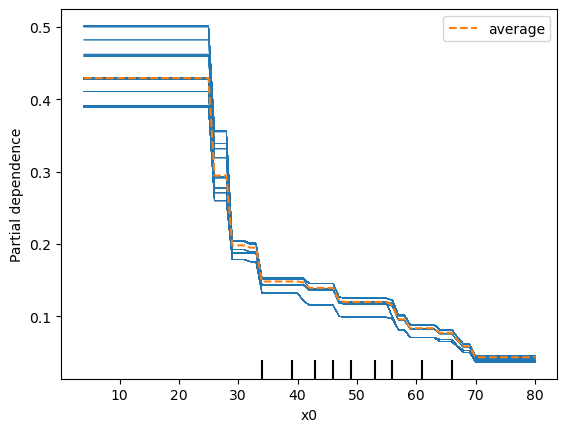

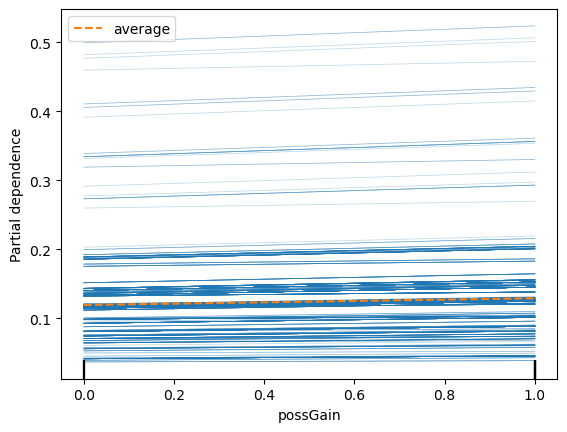

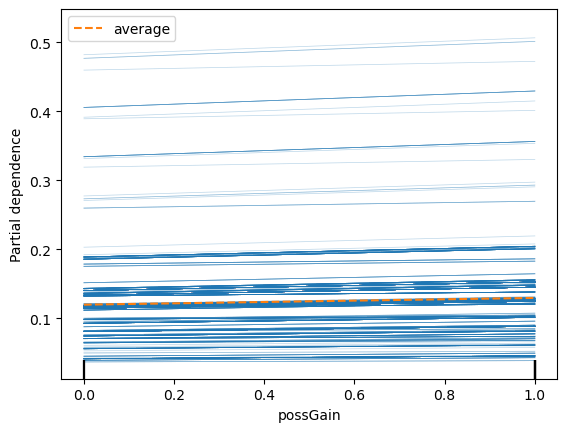

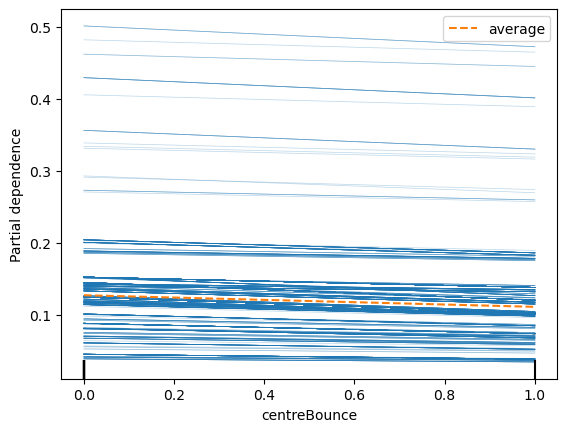

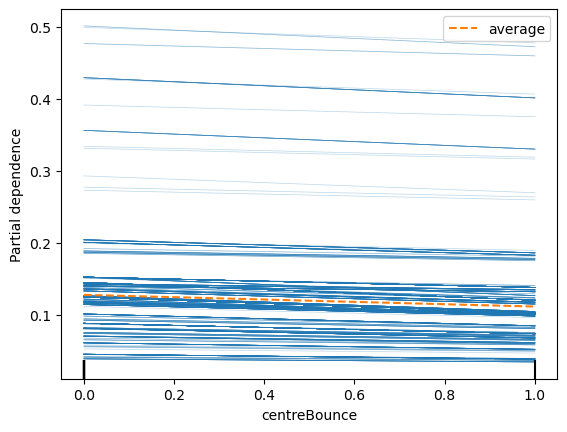

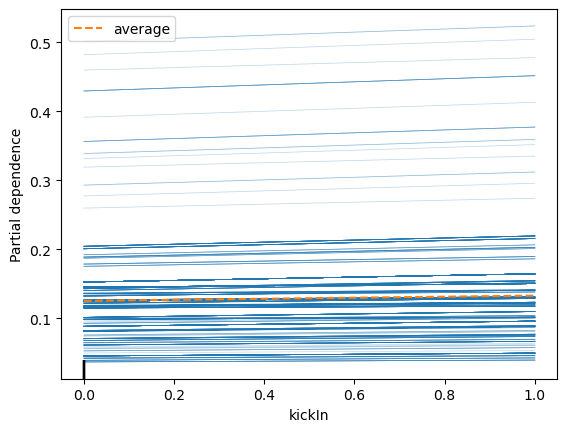

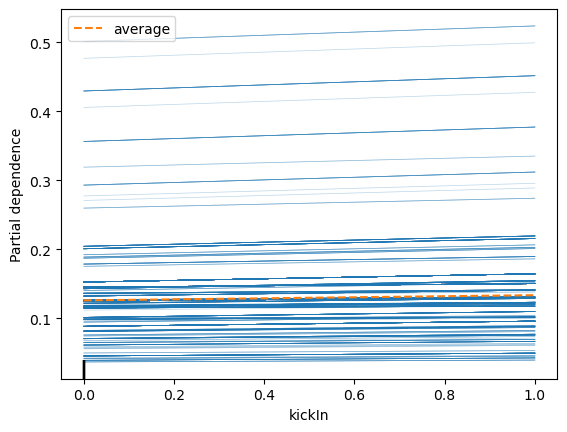

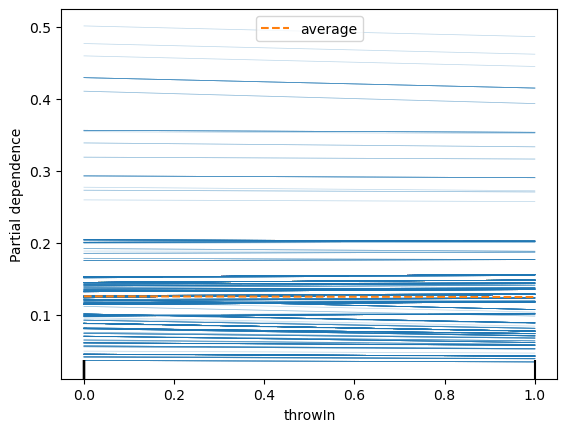

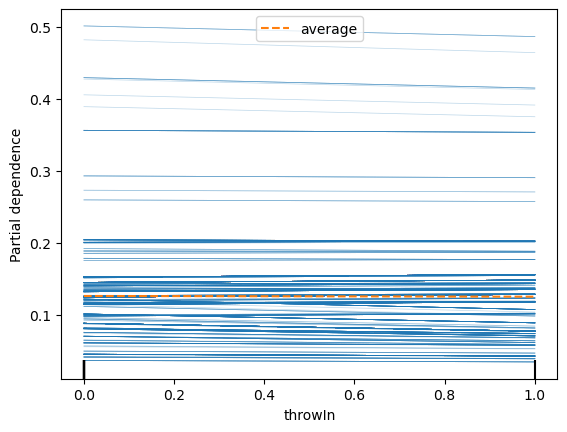

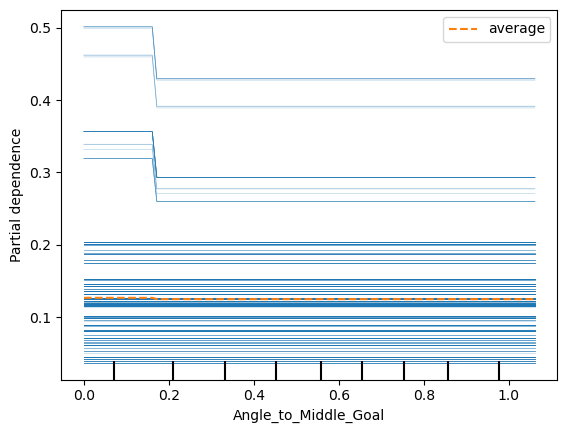

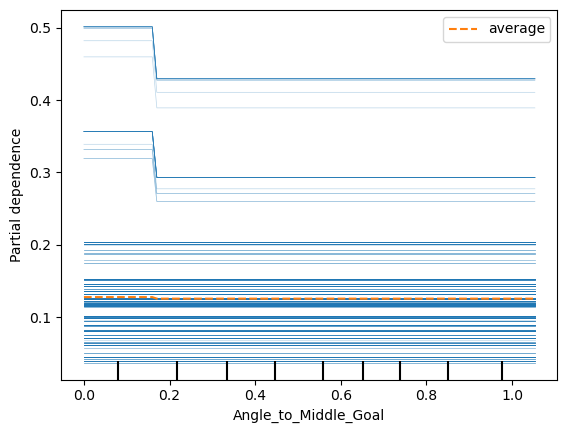

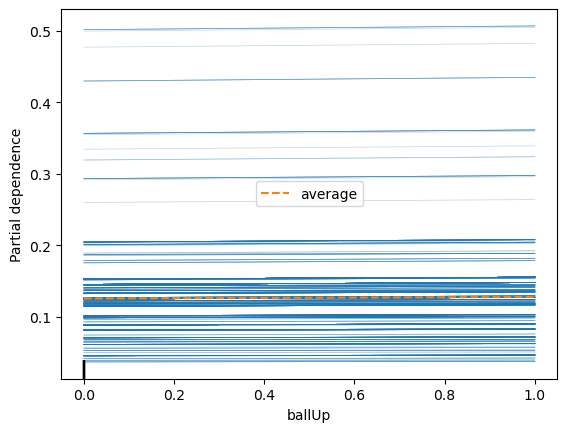

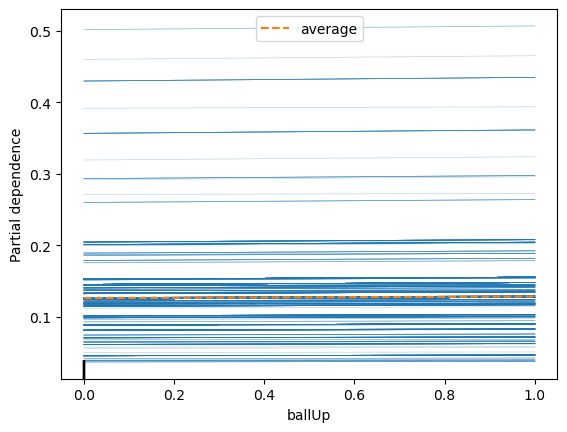

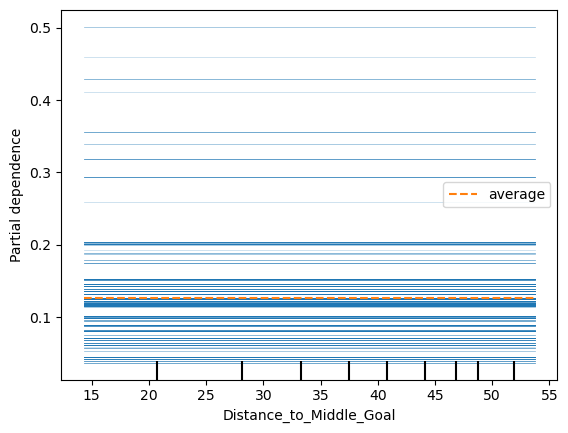

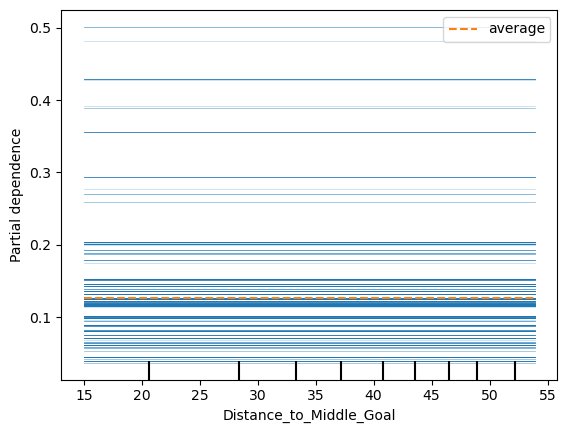

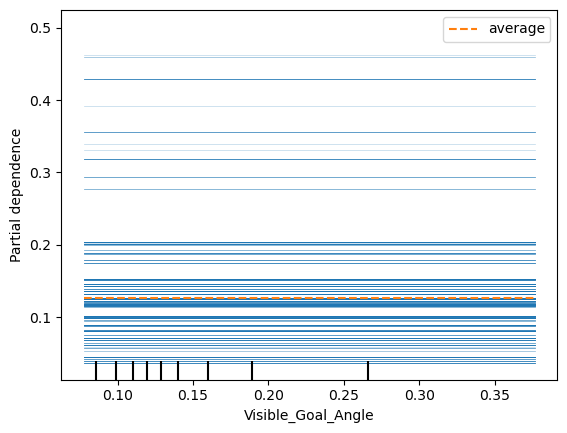

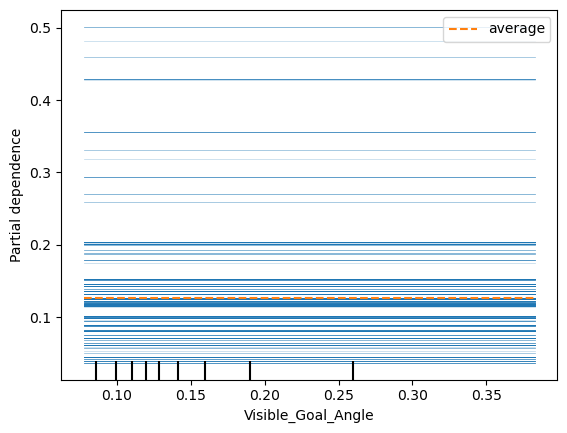

In [35]:
for col in top_10_features:
    train_xgb_evals.plot_ice([col])
    test_xgb_evals.plot_ice([col])

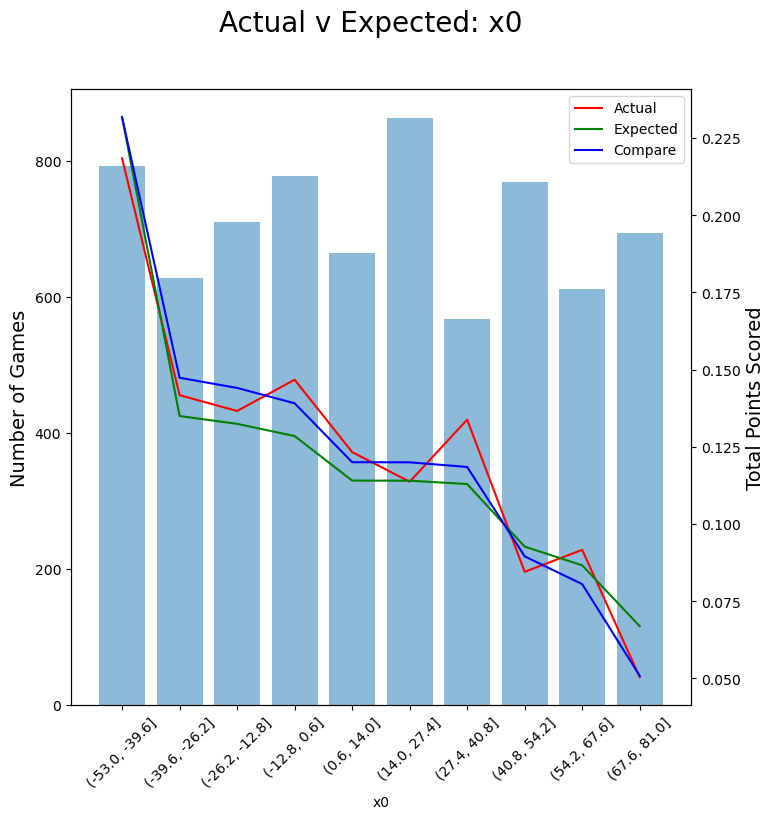

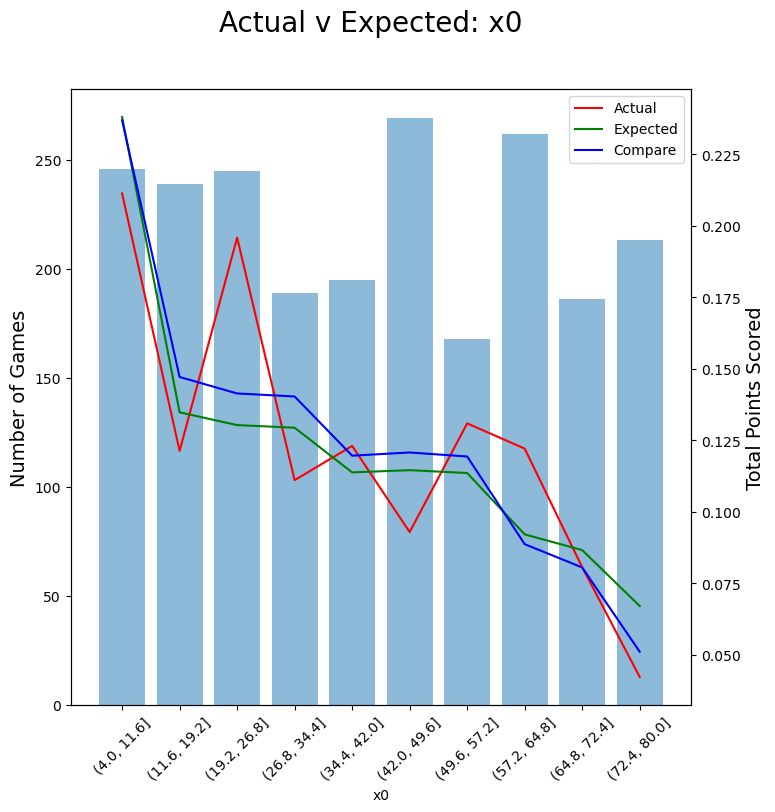

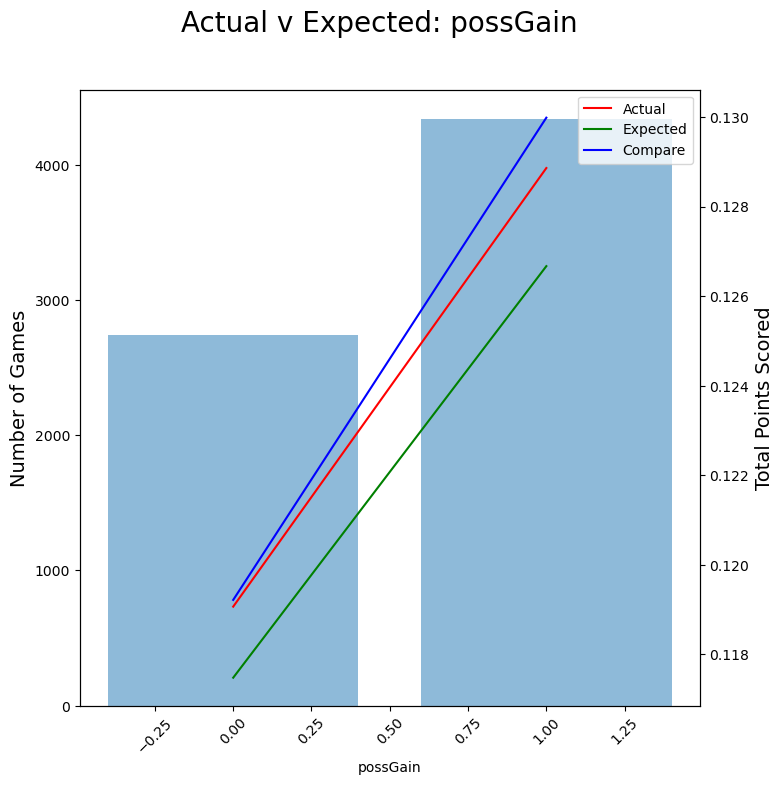

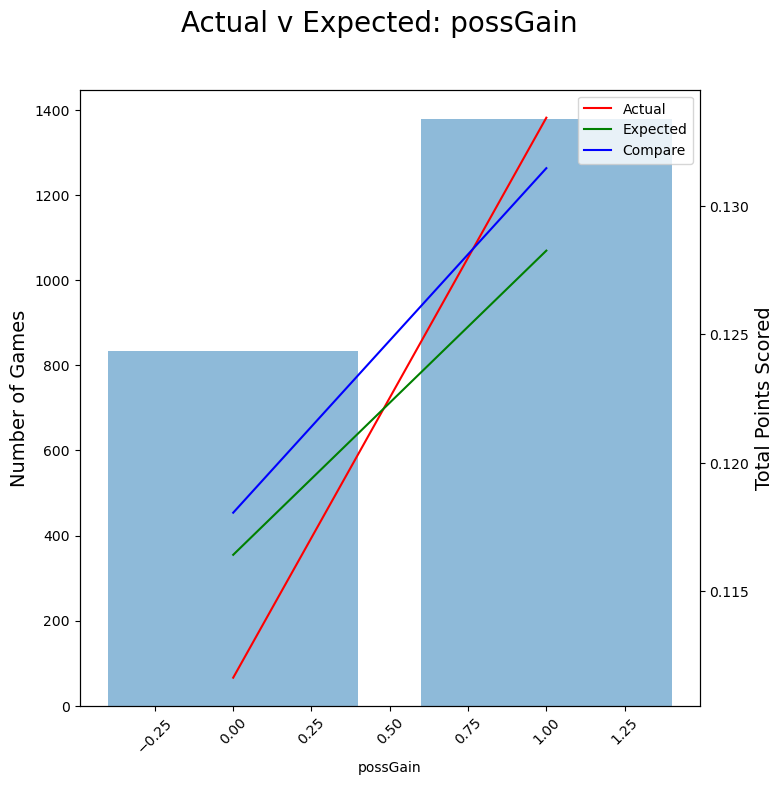

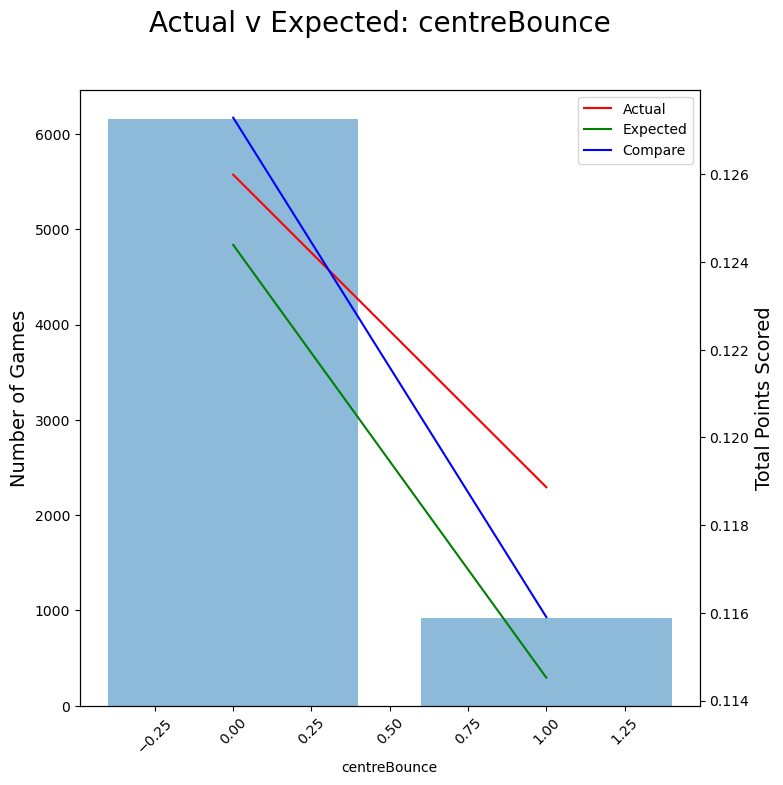

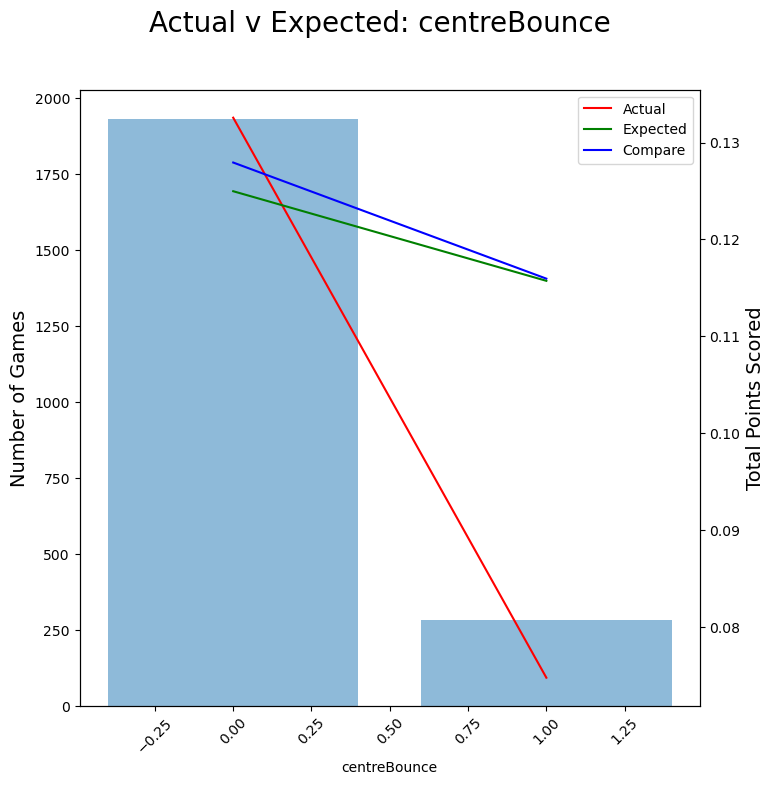

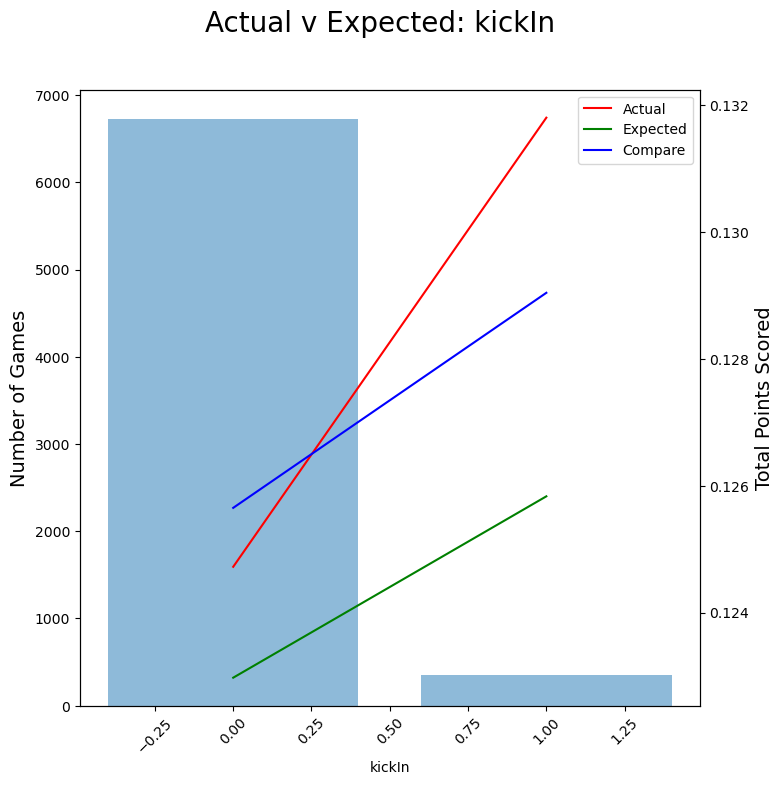

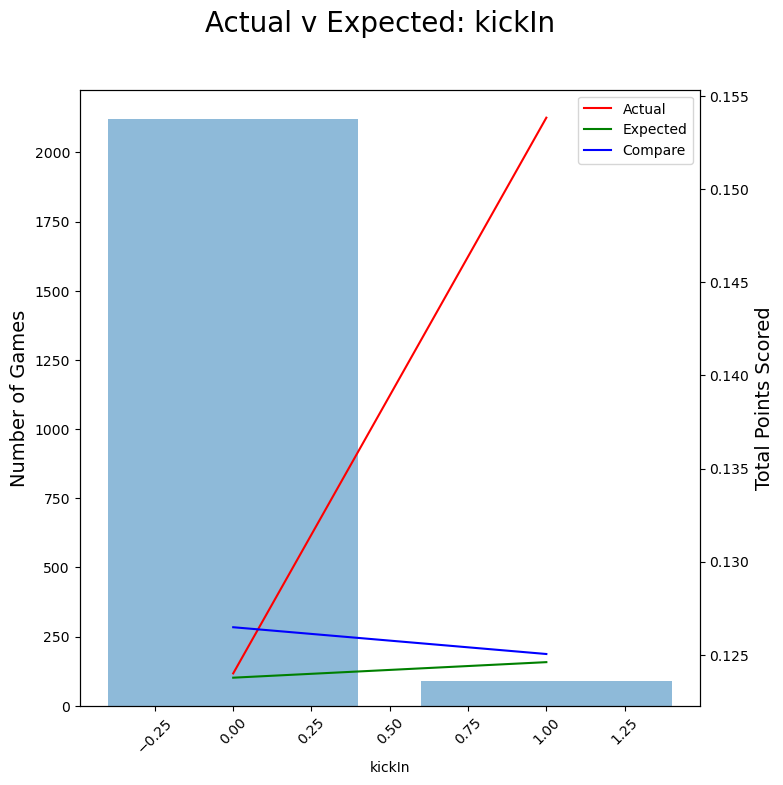

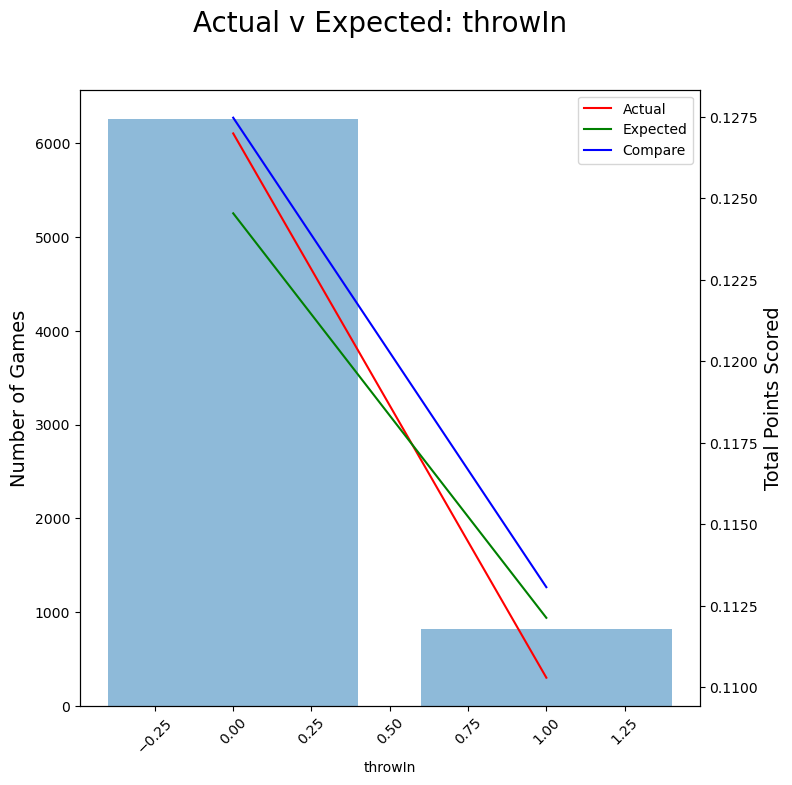

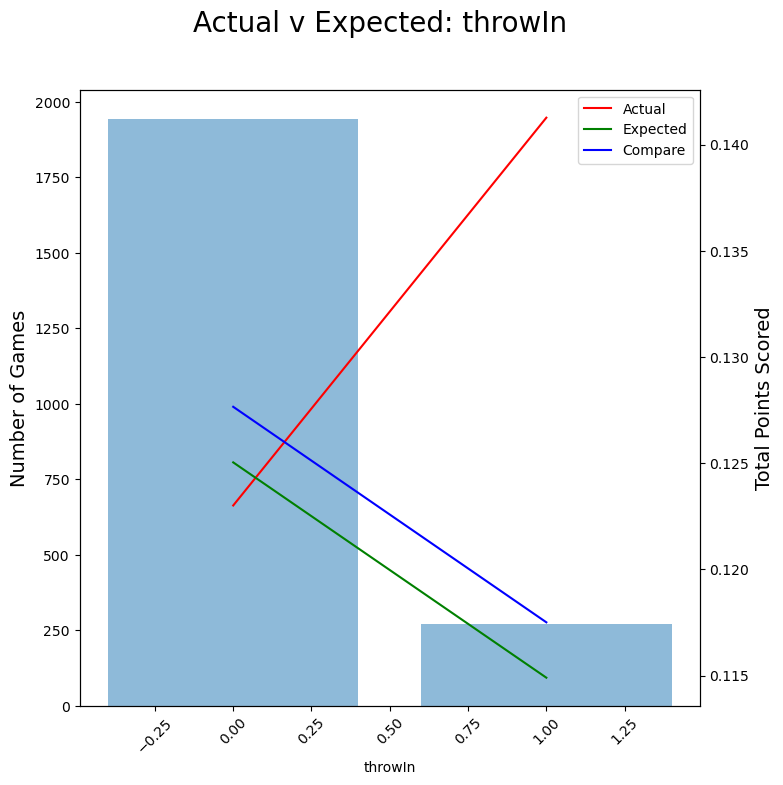

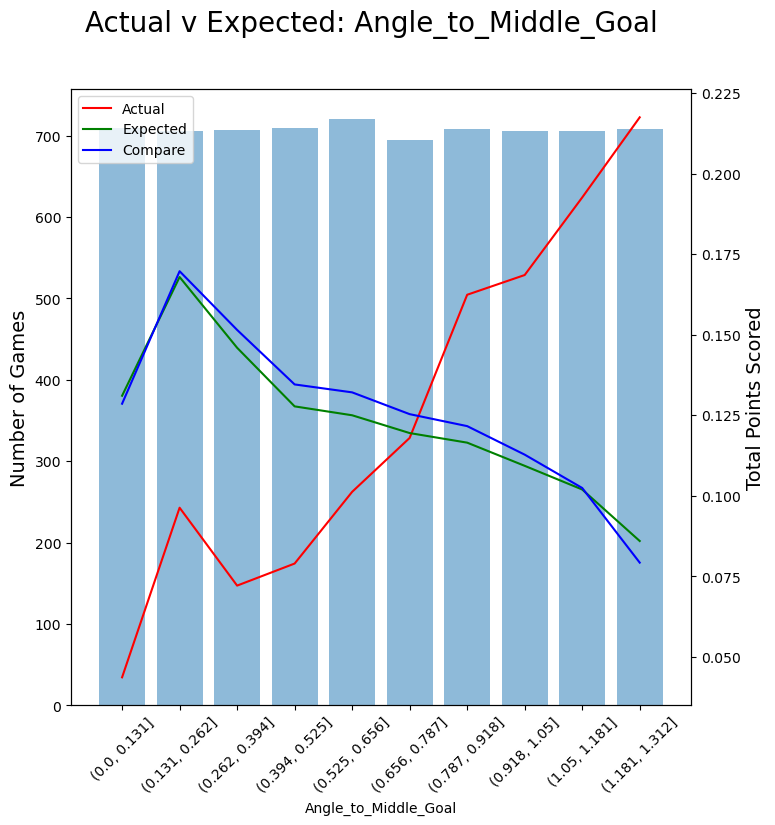

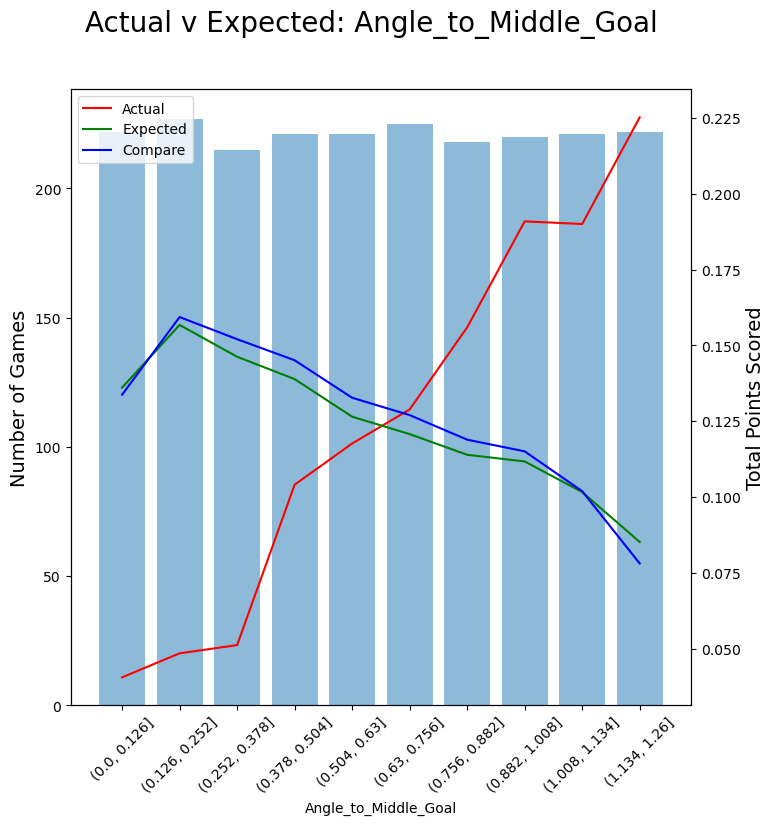

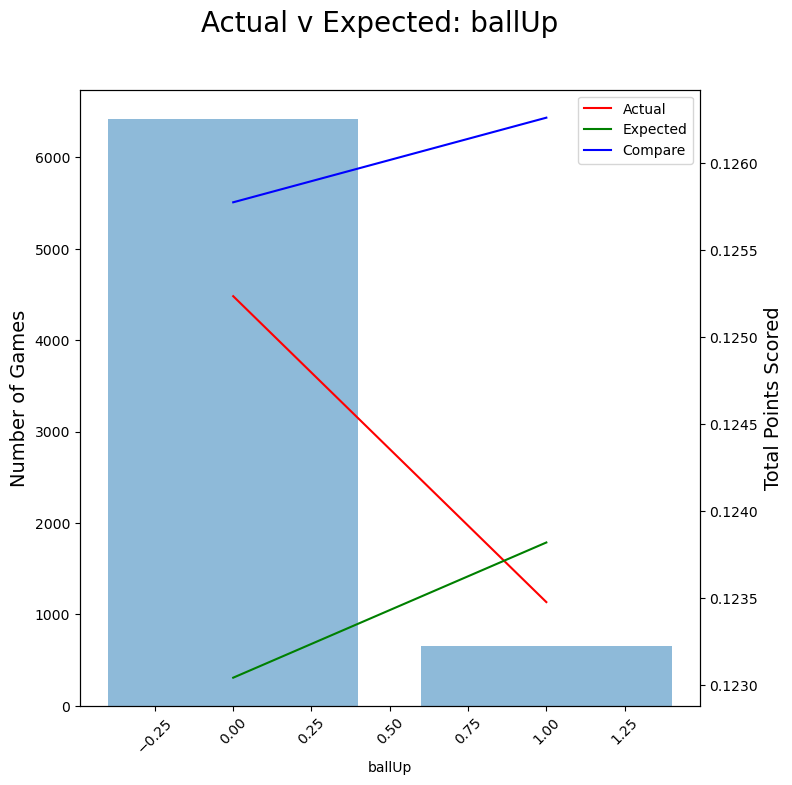

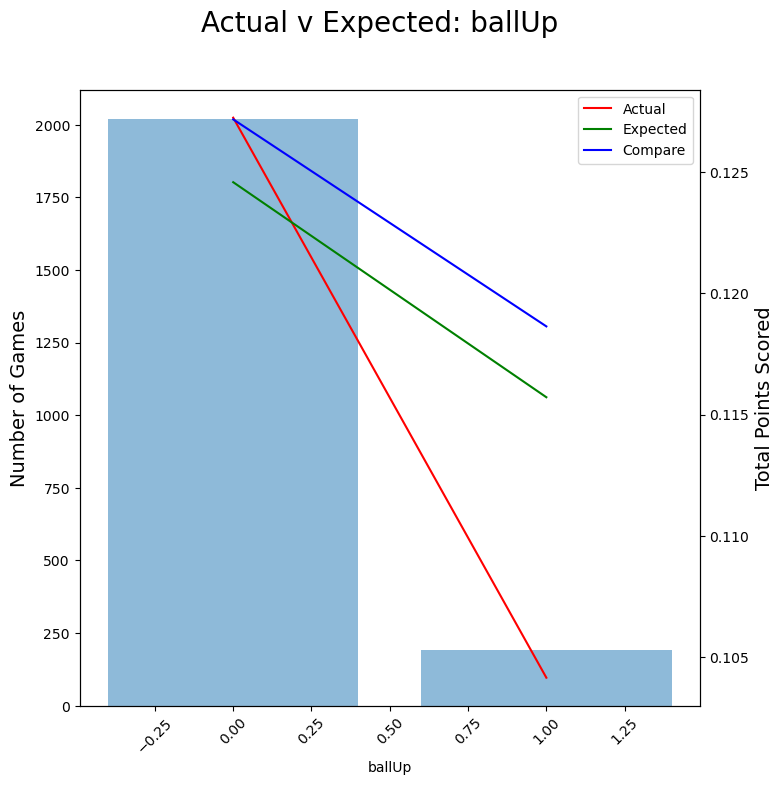

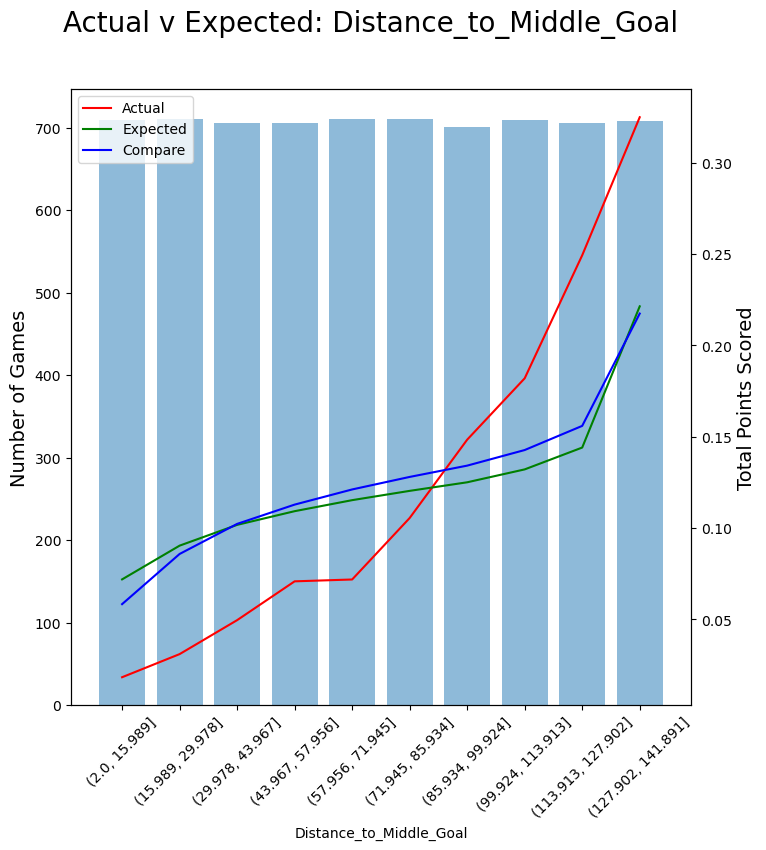

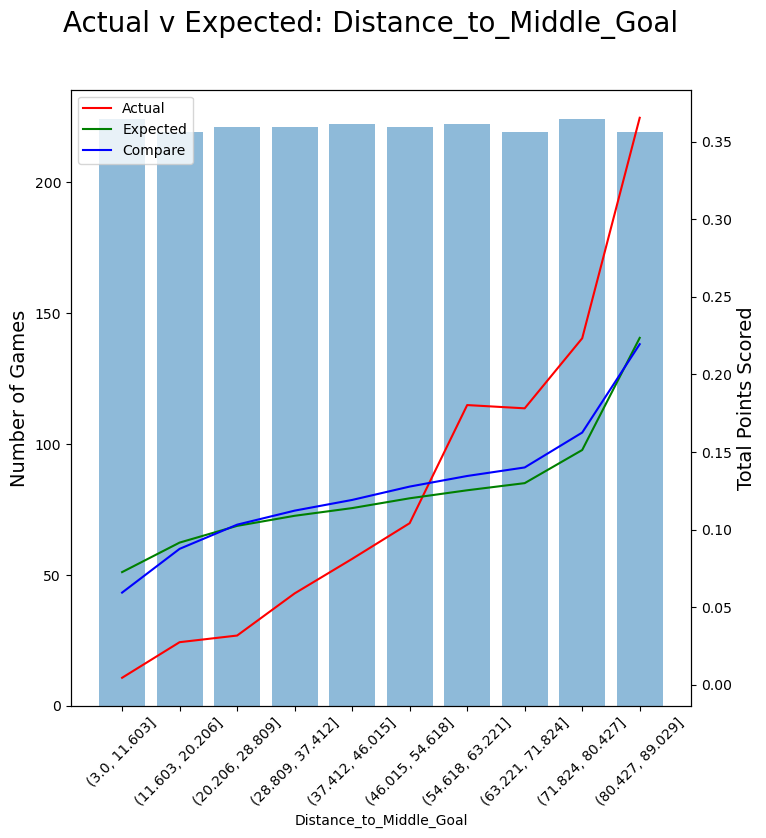

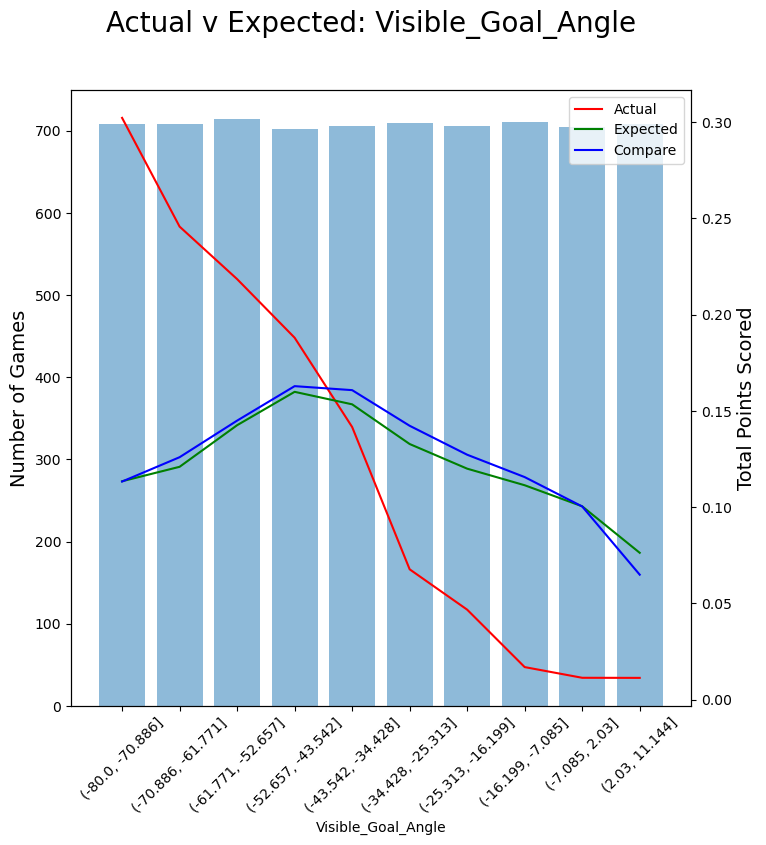

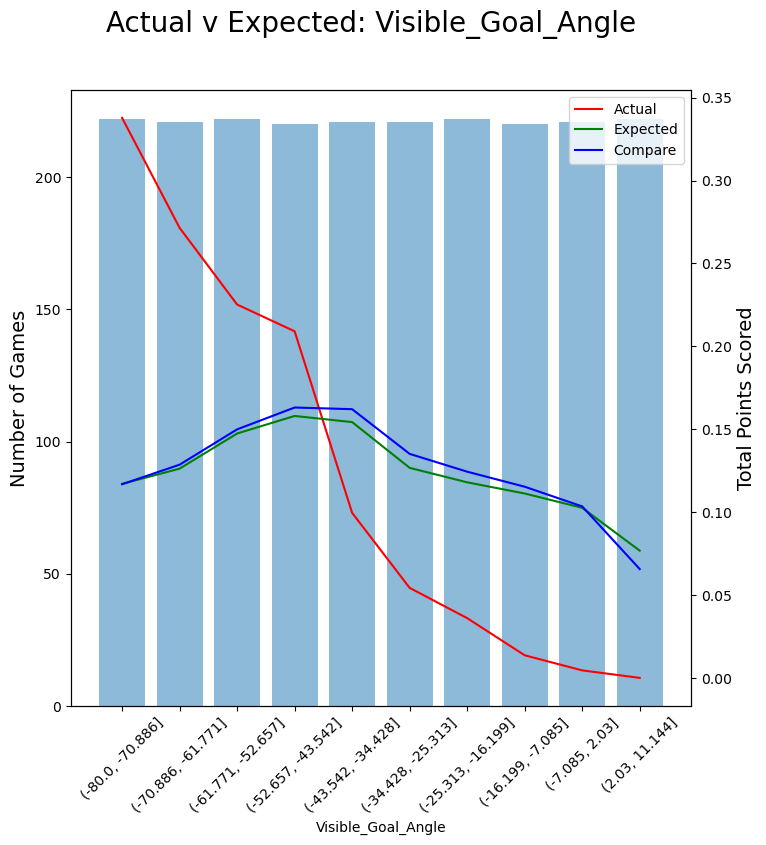

In [36]:
for col in top_10_features:
    train_xgb_evals.plot_feature_ave(col)
    test_xgb_evals.plot_feature_ave(col)

Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [37]:
train_xgb_evals.get_log_loss(), test_xgb_evals.get_log_loss()

Expected Log-Loss: 	0.3664
Compare Log-Loss: 	0.3654
Expected Log-Loss: 	0.3671
Compare Log-Loss: 	0.3658


((0.3664025118343686, 0.3664025118343686),
 (0.3671247418016787, 0.3671247418016787))

In [38]:
train_xgb_evals.get_brier_score_loss(), test_xgb_evals.get_brier_score_loss()

Expected Brier Score: 	0.1069
Compare Brier Score: 	0.1066
Expected Brier Score: 	0.1073
Compare Brier Score: 	0.1069


((0.10692254046329215, 0.10659265269162442),
 (0.10728165622071291, 0.10685426179805375))

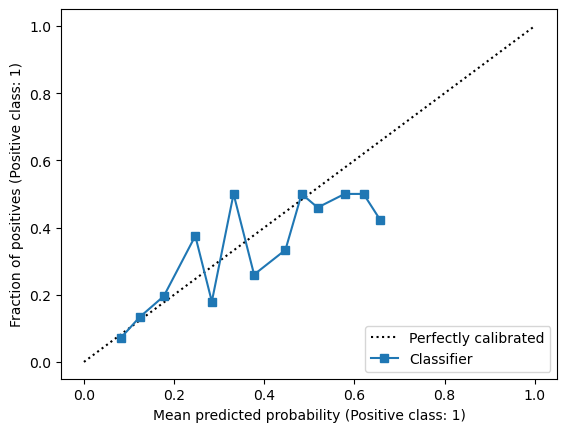

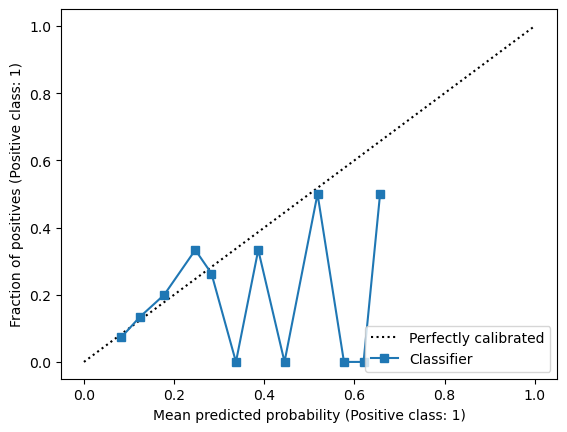

In [39]:
train_xgb_evals.display_calibration_curve(nbins=20)
test_xgb_evals.display_calibration_curve(nbins=20)

Potential New Features

In [ ]:
# list(df_modelling)

In [ ]:
potential_feature_list = [
    'Initial_State',
    'x0',
    'x1',
    'x2',
    'x3',
    'y0',
    'y1',
    'y2',
    'y3',
    'Quarter_Duration0',
    'Chain_Duration',
    'Time_Since_Last_Action',
    'Distance_Since_Last_Action',
    'Distance_to_Right_Goal_x',
    'Distance_to_Middle_y',
    'Visible_Goal_Angle',
    'Visible_Behind_Angle',
    'Squared_Distance_to_Middle_Goal',
    'Log_Distance_to_Middle_Goal'
]

In [ ]:
for col in potential_feature_list:
    train_xgb_evals.plot_feature_ave(col)